In [65]:
#%pip install axelrod
#!pip install statsmodels
#!pip install seaborn
#!conda list freetype

In [3]:
import axelrod as axl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Setup parameters

In [4]:
# Strategies from original axelrod tournament
players = [axl.TitForTat(), axl.FirstByTidemanAndChieruzzi(), axl.FirstByNydegger(), axl.FirstByGrofman(), axl.FirstByShubik(),
           axl.FirstBySteinAndRapoport(), axl.Grudger(), axl.FirstByDavis(), axl.FirstByGraaskamp(), axl.FirstByDowning(),
           axl.FirstByFeld(), axl.FirstByJoss(), axl.FirstByTullock(), axl.FirstByAnonymous(), axl.Random()]    


num_players = len(players)
num_reps = 5
num_turns = 200
seed = 1

### Running the tournament

In [5]:
tournament = axl.Tournament(players=players, repetitions=num_reps, turns=num_turns,seed=seed)
results = tournament.play(build_results = True, filename="results.csv")

Analysing: 100%|██████████| 25/25 [00:00<00:00, 44.40it/s]


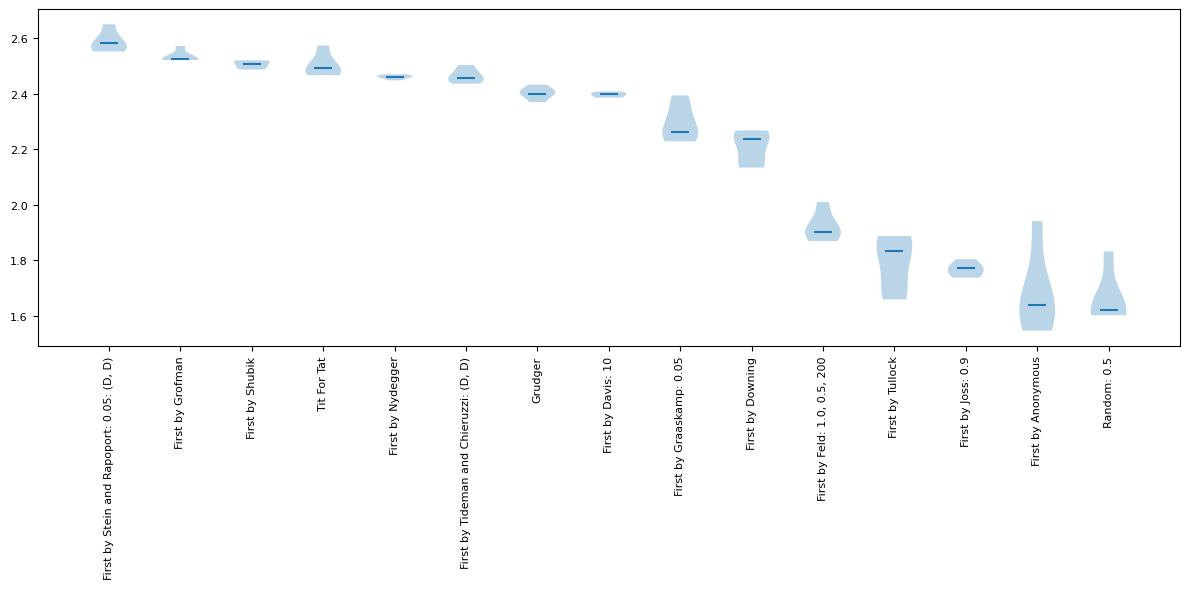

In [6]:
%matplotlib inline
plot = axl.Plot(results)
p = plot.boxplot()

In [7]:
results.write_summary("summary.csv")

In [8]:
results.scores

[[6979, 6917, 7019, 6910, 7208],
 [6853, 7011, 6885, 6930, 6823],
 [6857, 6904, 6891, 6888, 6918],
 [7077, 7203, 7081, 7076, 7062],
 [6987, 6966, 7058, 7054, 7023],
 [7422, 7234, 7147, 7160, 7248],
 [6721, 6753, 6637, 6813, 6723],
 [6682, 6719, 6745, 6694, 6727],
 [6529, 6242, 6336, 6705, 6315],
 [6289, 6351, 6265, 5977, 6011],
 [5411, 5236, 5326, 5629, 5315],
 [4895, 4968, 4867, 5052, 4972],
 [5212, 4648, 4753, 5134, 5286],
 [4538, 4332, 4644, 4595, 5436],
 [4487, 4500, 4538, 5132, 4616]]

In [9]:
results.normalised_scores

[[2.4925,
  2.470357142857143,
  2.5067857142857144,
  2.4678571428571425,
  2.5742857142857143],
 [2.4475000000000002,
  2.5039285714285713,
  2.4589285714285714,
  2.475,
  2.4367857142857146],
 [2.4489285714285716,
  2.4657142857142857,
  2.4610714285714286,
  2.46,
  2.470714285714286],
 [2.5275,
  2.5725000000000002,
  2.5289285714285716,
  2.527142857142857,
  2.5221428571428572],
 [2.495357142857143,
  2.4878571428571425,
  2.5207142857142855,
  2.5192857142857146,
  2.5082142857142857],
 [2.650714285714286,
  2.5835714285714286,
  2.5524999999999998,
  2.557142857142857,
  2.5885714285714285],
 [2.4003571428571426,
  2.411785714285714,
  2.370357142857143,
  2.4332142857142856,
  2.4010714285714285],
 [2.386428571428571,
  2.399642857142857,
  2.4089285714285715,
  2.3907142857142856,
  2.4025],
 [2.331785714285714,
  2.2292857142857145,
  2.262857142857143,
  2.394642857142857,
  2.2553571428571426],
 [2.2460714285714287,
  2.2682142857142855,
  2.2375,
  2.134642857142857,
  

In [10]:
results.payoffs[2] # this is a way to implement schulze method by match

[[3.0, 3.0, 3.0, 3.0, 3.0],
 [2.97, 2.97, 2.97, 2.97, 2.97],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [2.97, 2.97, 2.97, 2.97, 2.97],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [2.745, 2.745, 2.76, 2.775, 2.76],
 [0.075, 0.075, 0.075, 0.075, 0.075],
 [2.1, 2.31, 2.235, 2.175, 2.28],
 [2.685, 2.7, 2.625, 2.625, 2.655],
 [2.67, 2.745, 2.7, 2.745, 2.73],
 [1.5, 1.515, 1.525, 1.65, 1.66],
 [1.57, 1.49, 1.595, 1.455, 1.49]]

### Schulze method

#### Build pairwise wins matrix

In [11]:
pairwise_wins = np.zeros((num_players, num_players), dtype=float)

for strat_1 in range(num_players):
    for strat_2 in range(num_players):
        if strat_1 != strat_2:
            wins_1 = 0
            wins_2 = 0
            for rep in range(num_reps):
                score_1 = results.payoffs[strat_1][strat_2][rep]
                score_2 = results.payoffs[strat_2][strat_1][rep]
                if score_1 > score_2:
                    wins_1 += round((score_1-score_2) * num_turns)
            # Save score difference from strat_1 over strat_2 (if positive)
            pairwise_wins[strat_1][strat_2] = wins_1
        else:
            pairwise_wins[strat_1][strat_2] = np.nan    

print("Pairwise wins matrix:\n", pairwise_wins)

Pairwise wins matrix:
 [[  nan    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [  25.   nan   50.   30.   25.    0.   25.   25.  200.  150.    0.    0.
    40. 1915. 1945.]
 [   0.    0.   nan    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [   0.    0.    0.   nan    0.    0.    0.    0.  380.    0.    0.    0.
     0.    0.    0.]
 [   0.    0.    0.    0.   nan    0.    0.    0. 1470.    0.    0.    0.
     0. 1675. 1480.]
 [  25.    0.   50.   30.   25.   nan   25.   25.   25. 1425.    0.    0.
     0. 2070. 2270.]
 [   0.    0.    0.    0.    0.    0.   nan    0.  660.   50.    0.    0.
   105. 2480. 2430.]
 [   0.    0.    0.    0.    0.    0.    0.   nan  665.    0.    0.    0.
    70. 2355. 2235.]
 [   0.    0.  405.    0.    0.    0.    0.    0.   nan  395.    0.    0.
     0. 1560. 1895.]
 [   0.    0. 4825. 2830.   75.    0.    0.  125.    0.   nan    0.    0.
   150. 1960. 1835.]
 [  25.   10. 1300.  740.  

#### Apply Schulze method

In [12]:
def schulze_method(pairwise_matrix):
    n = len(pairwise_matrix)

    # Compute strongest paths (Floyd–Warshall style)
    for i in range(n):
        for j in range(n):
            if i != j:
                for k in range(n):
                    if i != k and j != k:
                        pairwise_matrix[j][k] = max(pairwise_matrix[j][k], min(pairwise_matrix[j][i], pairwise_matrix[i][k]))

    # Ranking: sort by scores difference in path strength
    ranking = sorted(range(n), key=lambda x: sum(pairwise_matrix[x][y] > pairwise_matrix[y][x] for y in range(n)), reverse=True)
    return ranking

schulze_ranking = schulze_method(pairwise_wins)
print("\nSchulze ranking:")
for pos, idx in enumerate(schulze_ranking, 1):
    print(f"{pos}. {players[idx]}")


Schulze ranking:
1. First by Joss: 0.9
2. First by Feld: 1.0, 0.5, 200
3. First by Tideman and Chieruzzi: (D, D)
4. First by Stein and Rapoport: 0.05: (D, D)
5. Grudger
6. First by Davis: 10
7. First by Tullock
8. First by Shubik
9. First by Graaskamp: 0.05
10. First by Downing
11. First by Anonymous
12. Random: 0.5
13. First by Grofman
14. Tit For Tat
15. First by Nydegger


In [13]:
print(pairwise_wins)

[[  nan    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [  25.   nan 1945.  815.  150.   25.   25.  125.  380.  515.    0.    0.
   150. 1915. 1945.]
 [   0.    0.   nan    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [  25.    0.  380.   nan  150.   25.   25.  125.  380.  380.    0.    0.
   150.  380.  380.]
 [  25.    0. 1675.  815.   nan   25.   25.  125. 1470.  515.    0.    0.
   150. 1675. 1480.]
 [  25.    0. 2270. 1425.  150.   nan   25.  125.  380. 1425.    0.    0.
   150. 2070. 2270.]
 [  25.    0. 2405.  815.  150.   25.   nan  125.  660.  515.    0.    0.
   150. 2480. 2430.]
 [  25.    0. 2350.  815.  150.   25.   25.   nan  665.  515.    0.    0.
   150. 2355. 2235.]
 [  25.    0. 1895.  815.  150.   25.   25.  125.   nan  515.    0.    0.
   150. 1560. 1895.]
 [  25.    0. 4825. 2830.  150.   25.   25.  125.  380.   nan    0.    0.
   150. 1960. 1835.]
 [  25.   10. 1300. 1275.  150.   25.   25.  125. 

In [14]:
print(schulze_ranking)

[11, 10, 1, 5, 6, 7, 12, 4, 8, 9, 13, 14, 3, 0, 2]


#### Schulze graph

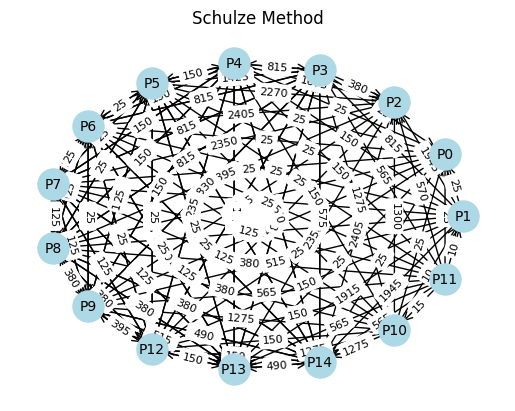


 Legend:
P0 - Tit For Tat
P1 - First by Tideman and Chieruzzi: (D, D)
P2 - First by Nydegger
P3 - First by Grofman
P4 - First by Shubik
P5 - First by Stein and Rapoport: 0.05: (D, D)
P6 - Grudger
P7 - First by Davis: 10
P8 - First by Graaskamp: 0.05
P9 - First by Downing
P10 - First by Feld: 1.0, 0.5, 200
P11 - First by Joss: 0.9
P12 - First by Tullock
P13 - First by Anonymous
P14 - Random: 0.5


In [15]:
def plot_margin_graph(pairwise_wins, labels=None):
    """
    Plot weighted directed graph for pairwise margins.
    Positive weight means row player beats column player by that margin.
    """
    n = pairwise_wins.shape[0]
    G = nx.DiGraph()

    if labels is None:
        labels = [f"S{i}" for i in range(n)]

    # Add edges with weight
    for i in range(n):
        for j in range(n):
            if i != j and pairwise_wins[i][j] > 0:
                G.add_edge(labels[i], labels[j], weight=int(pairwise_wins[i][j]))

    # Layout
    pos = nx.circular_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges with thickness proportional to margin
    edges = G.edges(data=True)
    widths = [max(1, w['weight'] / max(pairwise_wins.flatten()) * 10) for (_, _, w) in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=widths, arrowstyle='->', arrowsize=15)

    # Add labels showing margins
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Schulze Method")
    plt.axis("off")
    plt.show()

# Example usage:
a = plot_margin_graph(pairwise_wins, labels=[f"P{i}" for i in range(pairwise_wins.shape[0])])
a
print("\n Legend:")
for idx in range (0,num_players):
    print(f"P{idx} - {players[idx]}")

### Ranking comparasion

In [16]:
print("\nAxelrod classic ranking:")
for idx in range (0,num_players):
    print(f"{idx+1}. {results.ranked_names[idx]}")

print("\nSchulze ranking:")
for pos, idx in enumerate(schulze_ranking, 1):
    print(f"{pos}. {players[idx]}")


Axelrod classic ranking:
1. First by Stein and Rapoport: 0.05: (D, D)
2. First by Grofman
3. First by Shubik
4. Tit For Tat
5. First by Nydegger
6. First by Tideman and Chieruzzi: (D, D)
7. Grudger
8. First by Davis: 10
9. First by Graaskamp: 0.05
10. First by Downing
11. First by Feld: 1.0, 0.5, 200
12. First by Tullock
13. First by Joss: 0.9
14. First by Anonymous
15. Random: 0.5

Schulze ranking:
1. First by Joss: 0.9
2. First by Feld: 1.0, 0.5, 200
3. First by Tideman and Chieruzzi: (D, D)
4. First by Stein and Rapoport: 0.05: (D, D)
5. Grudger
6. First by Davis: 10
7. First by Tullock
8. First by Shubik
9. First by Graaskamp: 0.05
10. First by Downing
11. First by Anonymous
12. Random: 0.5
13. First by Grofman
14. Tit For Tat
15. First by Nydegger


In [17]:
classic_ranking = []  # list to match structure of schulze ranking
summary_df = pd.read_csv("summary.csv")
for i in range(num_players):
    classic_ranking.append(int(summary_df['Original_index'][i]))

In [18]:
schulze_ranking

[11, 10, 1, 5, 6, 7, 12, 4, 8, 9, 13, 14, 3, 0, 2]

In [19]:
classic_ranking

[5, 3, 4, 0, 2, 1, 6, 7, 8, 9, 10, 12, 11, 13, 14]

### Win-based tournament

In [20]:
wins = np.zeros((num_players, num_players), dtype=float)

for strat_1 in range(num_players):
    for strat_2 in range(num_players):
        if strat_1 != strat_2:
            wins_1 = 0
            wins_2 = 0
            for rep in range(num_reps):
                score_1 = results.payoffs[strat_1][strat_2][rep]
                score_2 = results.payoffs[strat_2][strat_1][rep]
                if score_1 > score_2:
                    wins_1 += 1 
            # Save win from strat_1 over strat_2 (if score is positive)
            wins[strat_1][strat_2] = wins_1
        else:
            wins[strat_1][strat_2] = np.nan    

print("Pairwise wins matrix:\n", wins)

Pairwise wins matrix:
 [[nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5. nan  5.  5.  5.  0.  5.  5.  5.  5.  0.  0.  3.  5.  5.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  0.  0.  0.  5.  0.  0.  0.  0.  5.  5.]
 [ 5.  0.  5.  5.  5. nan  5.  5.  5.  5.  0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0.  0.  0. nan  0.  5.  5.  0.  0.  5.  5.  5.]
 [ 0.  0.  0.  0.  0.  0.  0. nan  5.  0.  0.  0.  5.  5.  5.]
 [ 0.  0.  5.  0.  0.  0.  0.  0. nan  5.  0.  0.  0.  4.  5.]
 [ 0.  0.  5.  5.  5.  0.  0.  5.  0. nan  0.  0.  5.  4.  4.]
 [ 5.  2.  5.  5.  5.  5.  0.  0.  4.  5. nan  0.  4.  5.  5.]
 [ 5.  0.  5.  5.  5.  5.  0.  2.  5.  5.  3. nan  5.  5.  5.]
 [ 5.  0.  5.  5.  5.  5.  0.  0.  4.  0.  0.  0. nan  5.  5.]
 [ 2.  0.  5.  5.  0.  0.  0.  0.  0.  1.  0.  0.  0. nan  2.]
 [ 4.  0.  5.  5.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2. nan]]


In [21]:
def win_based_method(wins):
    n = len(wins)
    total_wins = []         # total wins of each strategy
    for i in range(n):
        suma = 0
        for j in range(n):
            if i != j:
                suma += wins[i][j]
        total_wins.append(int(suma))
    rankings = [i for i in range(num_players)]
    data = list(zip(rankings, total_wins))

    # Sort descending by total wins
    data.sort(key=lambda x: x[1], reverse=True)

    return [rank for rank, _ in data]

win_based_ranking = win_based_method(wins)
win_based_ranking

[11, 1, 5, 10, 12, 9, 6, 7, 8, 14, 4, 13, 3, 0, 2]

### Analysis of results

### Some general visualisation

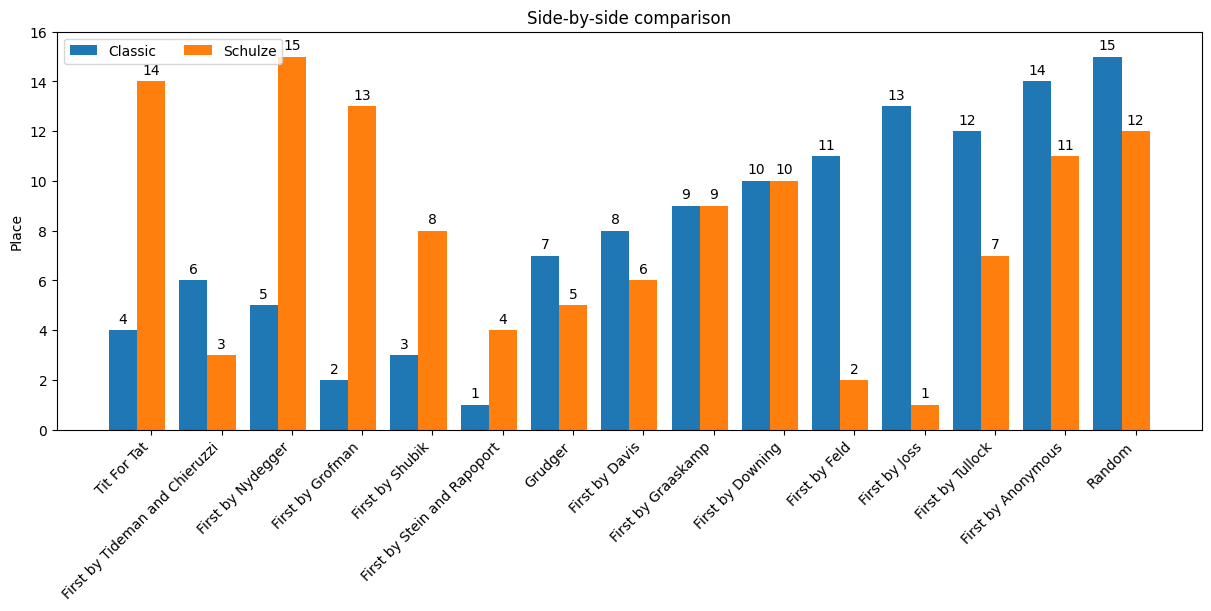

In [22]:
players_names = [p.name for p in players]
ranks = {
    'Classic': [classic_ranking.index(i)+1 for i in range(num_players)],
    'Schulze': [schulze_ranking.index(i)+1 for i in range(num_players)]
}

x = np.arange(len(players))
width = 0.4  
multiplier = 0
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

for type, place in ranks.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, place, width, label=type)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Place')
ax.set_title('Side-by-side comparison')
ax.set_xticks(x + width, players_names, rotation=45, ha="right")
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, num_players + 1)

plt.show()

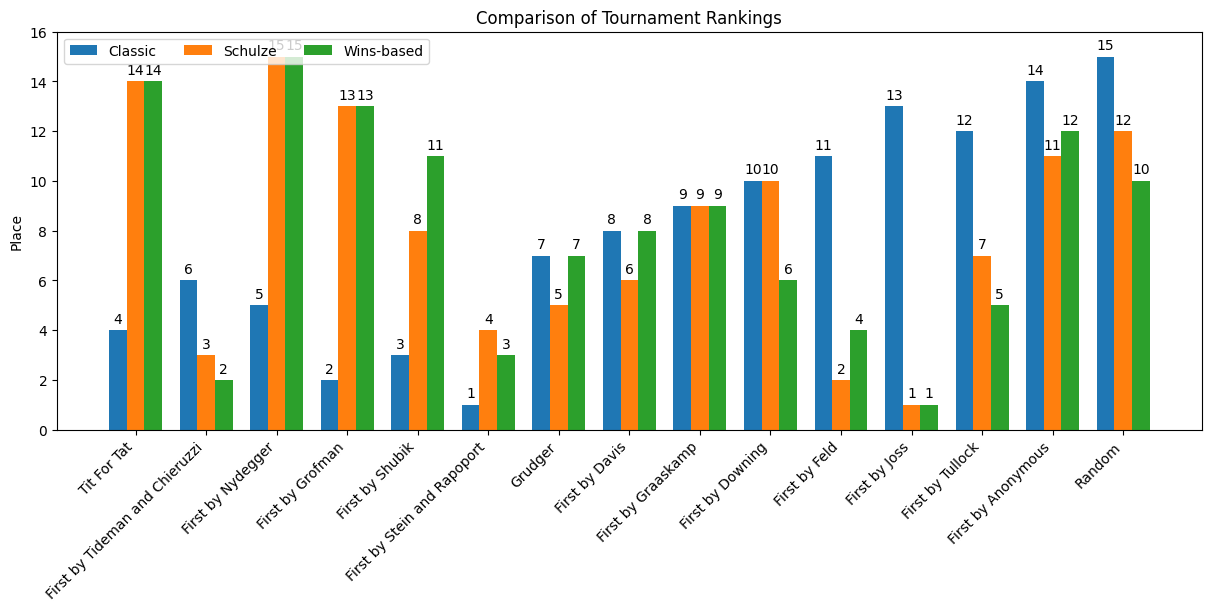

In [23]:
players_names = [p.name for p in players]

# Create dictionary of rankings for all 3 methods
ranks = {
    'Classic':  [classic_ranking.index(i) + 1 for i in range(num_players)],
    'Schulze':  [schulze_ranking.index(i) + 1 for i in range(num_players)],
    'Wins-based': [win_based_ranking.index(i) + 1 for i in range(num_players)]
}

# Visualization
x = np.arange(len(players))
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

for type, place in ranks.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, place, width, label=type)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Place')
ax.set_title('Comparison of Tournament Rankings')
ax.set_xticks(x + width, players_names, rotation=45, ha="right")
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, num_players + 1)

plt.show()

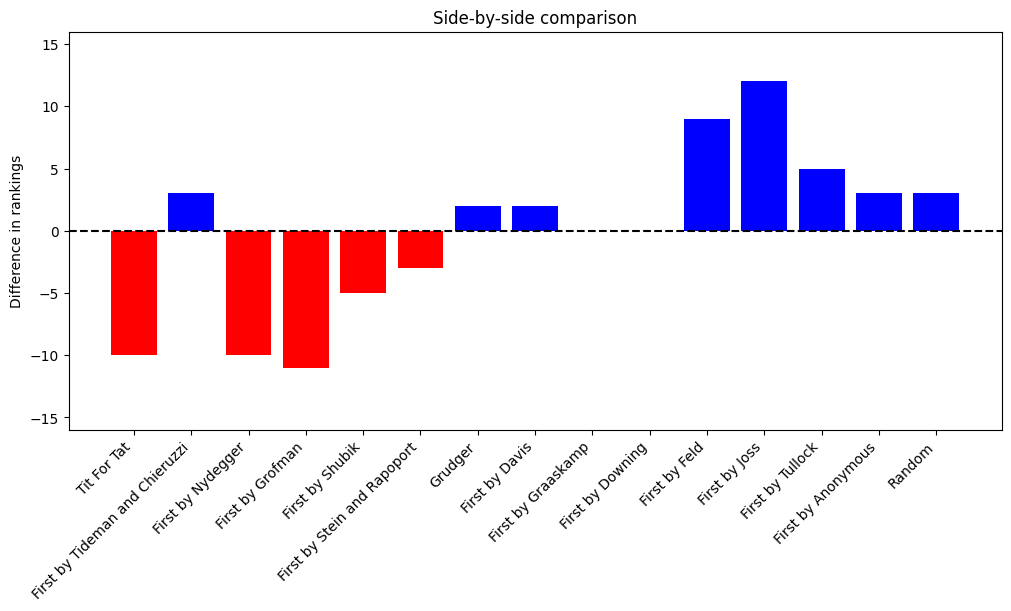

In [24]:
diffs = [classic_ranking.index(s) - schulze_ranking.index(s) for s in range(num_players)]

x = np.arange(len(players))
width = 1  
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.bar(players_names,diffs,color=['b' if d >=0 else 'r' for d in diffs ])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Difference in rankings')
ax.set_title('Side-by-side comparison')
ax.set_xticks(x, players_names, rotation=45, ha="right")
ax.set_ylim(-num_players-1, num_players + 1)

plt.show()

#### Creating all-in-one dataframe

In [25]:
all_tournaments_df = pd.read_csv("summary.csv")    # All tournaments rankings and main metrics
schulze_rank_map = {idx: rank  for rank, idx in enumerate(schulze_ranking)}
win_rank_map = {idx: rank  for rank, idx in enumerate(win_based_ranking)}

# Add new columns to the dataframe by mapping
all_tournaments_df["Schulze_Rank"] = all_tournaments_df["Original_index"].map(schulze_rank_map)
all_tournaments_df["Win_Based_Rank"] = all_tournaments_df["Original_index"].map(win_rank_map)

new_order = ["Rank","Schulze_Rank", "Win_Based_Rank"] + [col for col in all_tournaments_df.columns if col not in ["Rank","Schulze_Rank", "Win_Based_Rank"]]
all_tournaments_df = all_tournaments_df[new_order]
# Save to file
all_tournaments_df.to_csv("all_tournaments_rankings.csv", index=False)

# Normalised ranks
all_tournaments_df_norm = all_tournaments_df
rank_cols = ["Rank", "Schulze_Rank", "Win_Based_Rank"]
for col in rank_cols:
    min_val = all_tournaments_df[col].min()
    max_val = all_tournaments_df[col].max()
    all_tournaments_df_norm[col] = (all_tournaments_df[col] - min_val) / (max_val - min_val)
all_tournaments_df_norm.to_csv("all_tournaments_rankings_norm.csv", index=False)
all_tournaments_df = pd.read_csv("all_tournaments_rankings.csv")

In [26]:
def compute_rank_correlations(df):
    """
    Returns Spearman correlations pairwise.
    """
    a = df['Rank']
    b = df['Win_Based_Rank']
    c = df['Schulze_Rank']
    out = {}
    out['score_vs_wins'] = spearmanr(a, b).correlation
    out['score_vs_schulze'] = spearmanr(a, c).correlation
    out['wins_vs_schulze'] = spearmanr(b, c).correlation
    return out

compute_rank_correlations(all_tournaments_df)

{'score_vs_wins': np.float64(-0.23571428571428568),
 'score_vs_schulze': np.float64(-0.14285714285714282),
 'wins_vs_schulze': np.float64(0.914285714285714)}

In [27]:
all_tournaments_df.head(5)

,Rank,Schulze_Rank,Win_Based_Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,Original_index,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,3,2,"First by Stein and Rapoport: 0.05: (D, D)",2.583571,0.602929,10.0,1.0,5,0.559143,0.043786,0.128000,0.269071,0.980995,0.238937,0.591605,0.000000
1,1,12,12,First by Grofman,2.527500,0.848357,1.0,1.0,3,0.704000,0.144357,0.068000,0.083643,1.000000,0.263313,0.271063,1.000000
2,2,7,10,First by Shubik,2.508214,0.613429,3.0,1.0,4,0.568857,0.044571,0.103286,0.283286,1.000000,0.000000,0.142896,0.111489
3,3,13,13,Tit For Tat,2.492500,0.717357,0.0,1.0,0,0.640857,0.076500,0.074286,0.208357,1.000000,0.000000,1.000000,0.000000
4,4,14,14,First by Nydegger,2.461071,0.996000,0.0,1.0,2,0.816714,0.179286,0.001786,0.002214,0.999852,0.997348,0.215909,0.394231


In [28]:
all_tournaments_df[all_tournaments_df["Schulze_Rank"]<3]

,Rank,Schulze_Rank,Win_Based_Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,Original_index,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
5,5,2,1,"First by Tideman and Chieruzzi: (D, D)",2.458929,0.597286,11.0,1.0,1,0.580000,0.017286,0.080429,0.322286,0.996791,0.083736,0.379202,0.0
10,10,1,3,"First by Feld: 1.0, 0.5, 200",1.902143,0.290357,10.0,1.0,10,0.231857,0.058500,0.129357,0.580286,0.887230,0.000000,0.810846,0.0
12,12,0,0,First by Joss: 0.9,1.774286,0.289500,11.0,1.0,11,0.228071,0.061429,0.093357,0.617143,0.862703,0.000000,0.910712,0.0


In [29]:
def compute_any_correlations(df,col_name):
    a = df['Rank']
    b = df['Win_Based_Rank']
    c = df['Schulze_Rank']
    d = df[col_name]
    out = {}
    out['Classic'] = spearmanr(a, d).correlation
    out['Win-Based'] = spearmanr(b, d).correlation
    out['Schulze'] = spearmanr(c, d).correlation
    return out

compute_any_correlations(all_tournaments_df,"Median_score")

{'Classic': np.float64(-1.0),
 'Win-Based': np.float64(0.23571428571428568),
 'Schulze': np.float64(0.14285714285714282)}

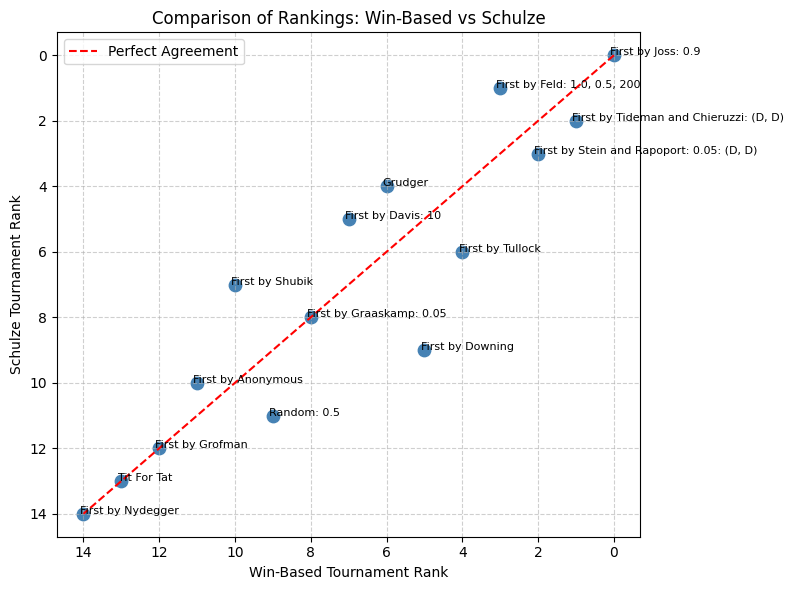

In [30]:

classic_ranks = all_tournaments_df["Win_Based_Rank"]
schulze_ranks = all_tournaments_df["Schulze_Rank"]
names = all_tournaments_df["Strategy"] if "Strategy" in all_tournaments_df.columns else all_tournaments_df["Name"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(classic_ranks, schulze_ranks, color='steelblue', s=80)

# Label each point with strategy name
for i, name in enumerate(names):
    plt.text(classic_ranks[i] + 0.1, schulze_ranks[i], name, fontsize=8)

# Add diagonal (line of perfect agreement)
plt.plot([min(classic_ranks), max(classic_ranks)], 
         [min(classic_ranks), max(classic_ranks)], 
         'r--', label='Perfect Agreement')

# Axis labels and title
plt.xlabel("Win-Based Tournament Rank")
plt.ylabel("Schulze Tournament Rank")
plt.title("Comparison of Rankings: Win-Based vs Schulze")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
model = smf.ols('Schulze_Rank ~ Initial_C_rate + CC_rate + DD_rate + CD_rate + DC_rate + CC_to_C_rate + DD_to_C_rate', data=all_tournaments_df_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Schulze_Rank   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     4.808
Date:                Thu, 06 Nov 2025   Prob (F-statistic):             0.0228
Time:                        08:19:04   Log-Likelihood:                 7.8067
No. Observations:                  15   AIC:                            -1.613
Df Residuals:                       8   BIC:                             3.343
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0594      0.719      0.

d:\Programming\JupyterLabProjects\TournamentRemix\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


In [32]:
X = all_tournaments_df[['Initial_C_rate', 'CC_rate' , 'DD_rate' , 'CD_rate' , 'DC_rate' , 'CC_to_C_rate' , 'DD_to_C_rate']]
X = sm.add_constant(X) 

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


print(vif_data)

          feature        VIF
0           const   0.000000
1  Initial_C_rate   2.466417
2         CC_rate        inf
3         DD_rate        inf
4         CD_rate        inf
5         DC_rate        inf
6    CC_to_C_rate  13.683064
7    DD_to_C_rate   2.842846


d:\Programming\JupyterLabProjects\TournamentRemix\.venv\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
d:\Programming\JupyterLabProjects\TournamentRemix\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [33]:
model = smf.ols('CC_to_C_rate ~ Initial_C_rate +  DD_rate + CD_rate + DC_rate  + DD_to_C_rate', data=all_tournaments_df_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           CC_to_C_rate   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     22.83
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           7.28e-05
Time:                        08:19:04   Log-Likelihood:                 26.222
No. Observations:                  15   AIC:                            -40.44
Df Residuals:                       9   BIC:                            -36.19
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2624      0.112     11.

d:\Programming\JupyterLabProjects\TournamentRemix\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


In [34]:
model = smf.ols('CC_rate ~ Initial_C_rate  + DD_rate + CD_rate + DC_rate + CC_to_C_rate + DD_to_C_rate', data=all_tournaments_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                CC_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.200e+30
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          2.28e-119
Time:                        08:19:04   Log-Likelihood:                 519.93
No. Observations:                  15   AIC:                            -1026.
Df Residuals:                       8   BIC:                            -1021.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0000   2.34e-15   4.26e

d:\Programming\JupyterLabProjects\TournamentRemix\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


In [35]:
spearmanr(all_tournaments_df_norm["CC_rate"], all_tournaments_df_norm["DD_rate"]).correlation

np.float64(-0.7535714285714286)

### Bigger tournament

In [36]:
filterset = {
    'manipulates_state': False,
   'long_run_time': False,
   #'stochastic': False,
   'manipulates_source': False,
   'inspects_source': False
}
strategies = axl.filtered_strategies(filterset)

players =[]
for strat in strategies:
    players.append(strat())
num_players = len(players)

In [37]:
tournament = axl.Tournament(players=players, repetitions=num_reps, turns=num_turns,seed=seed)
results = tournament.play(build_results = True, filename="big_results.csv")

Analysing: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


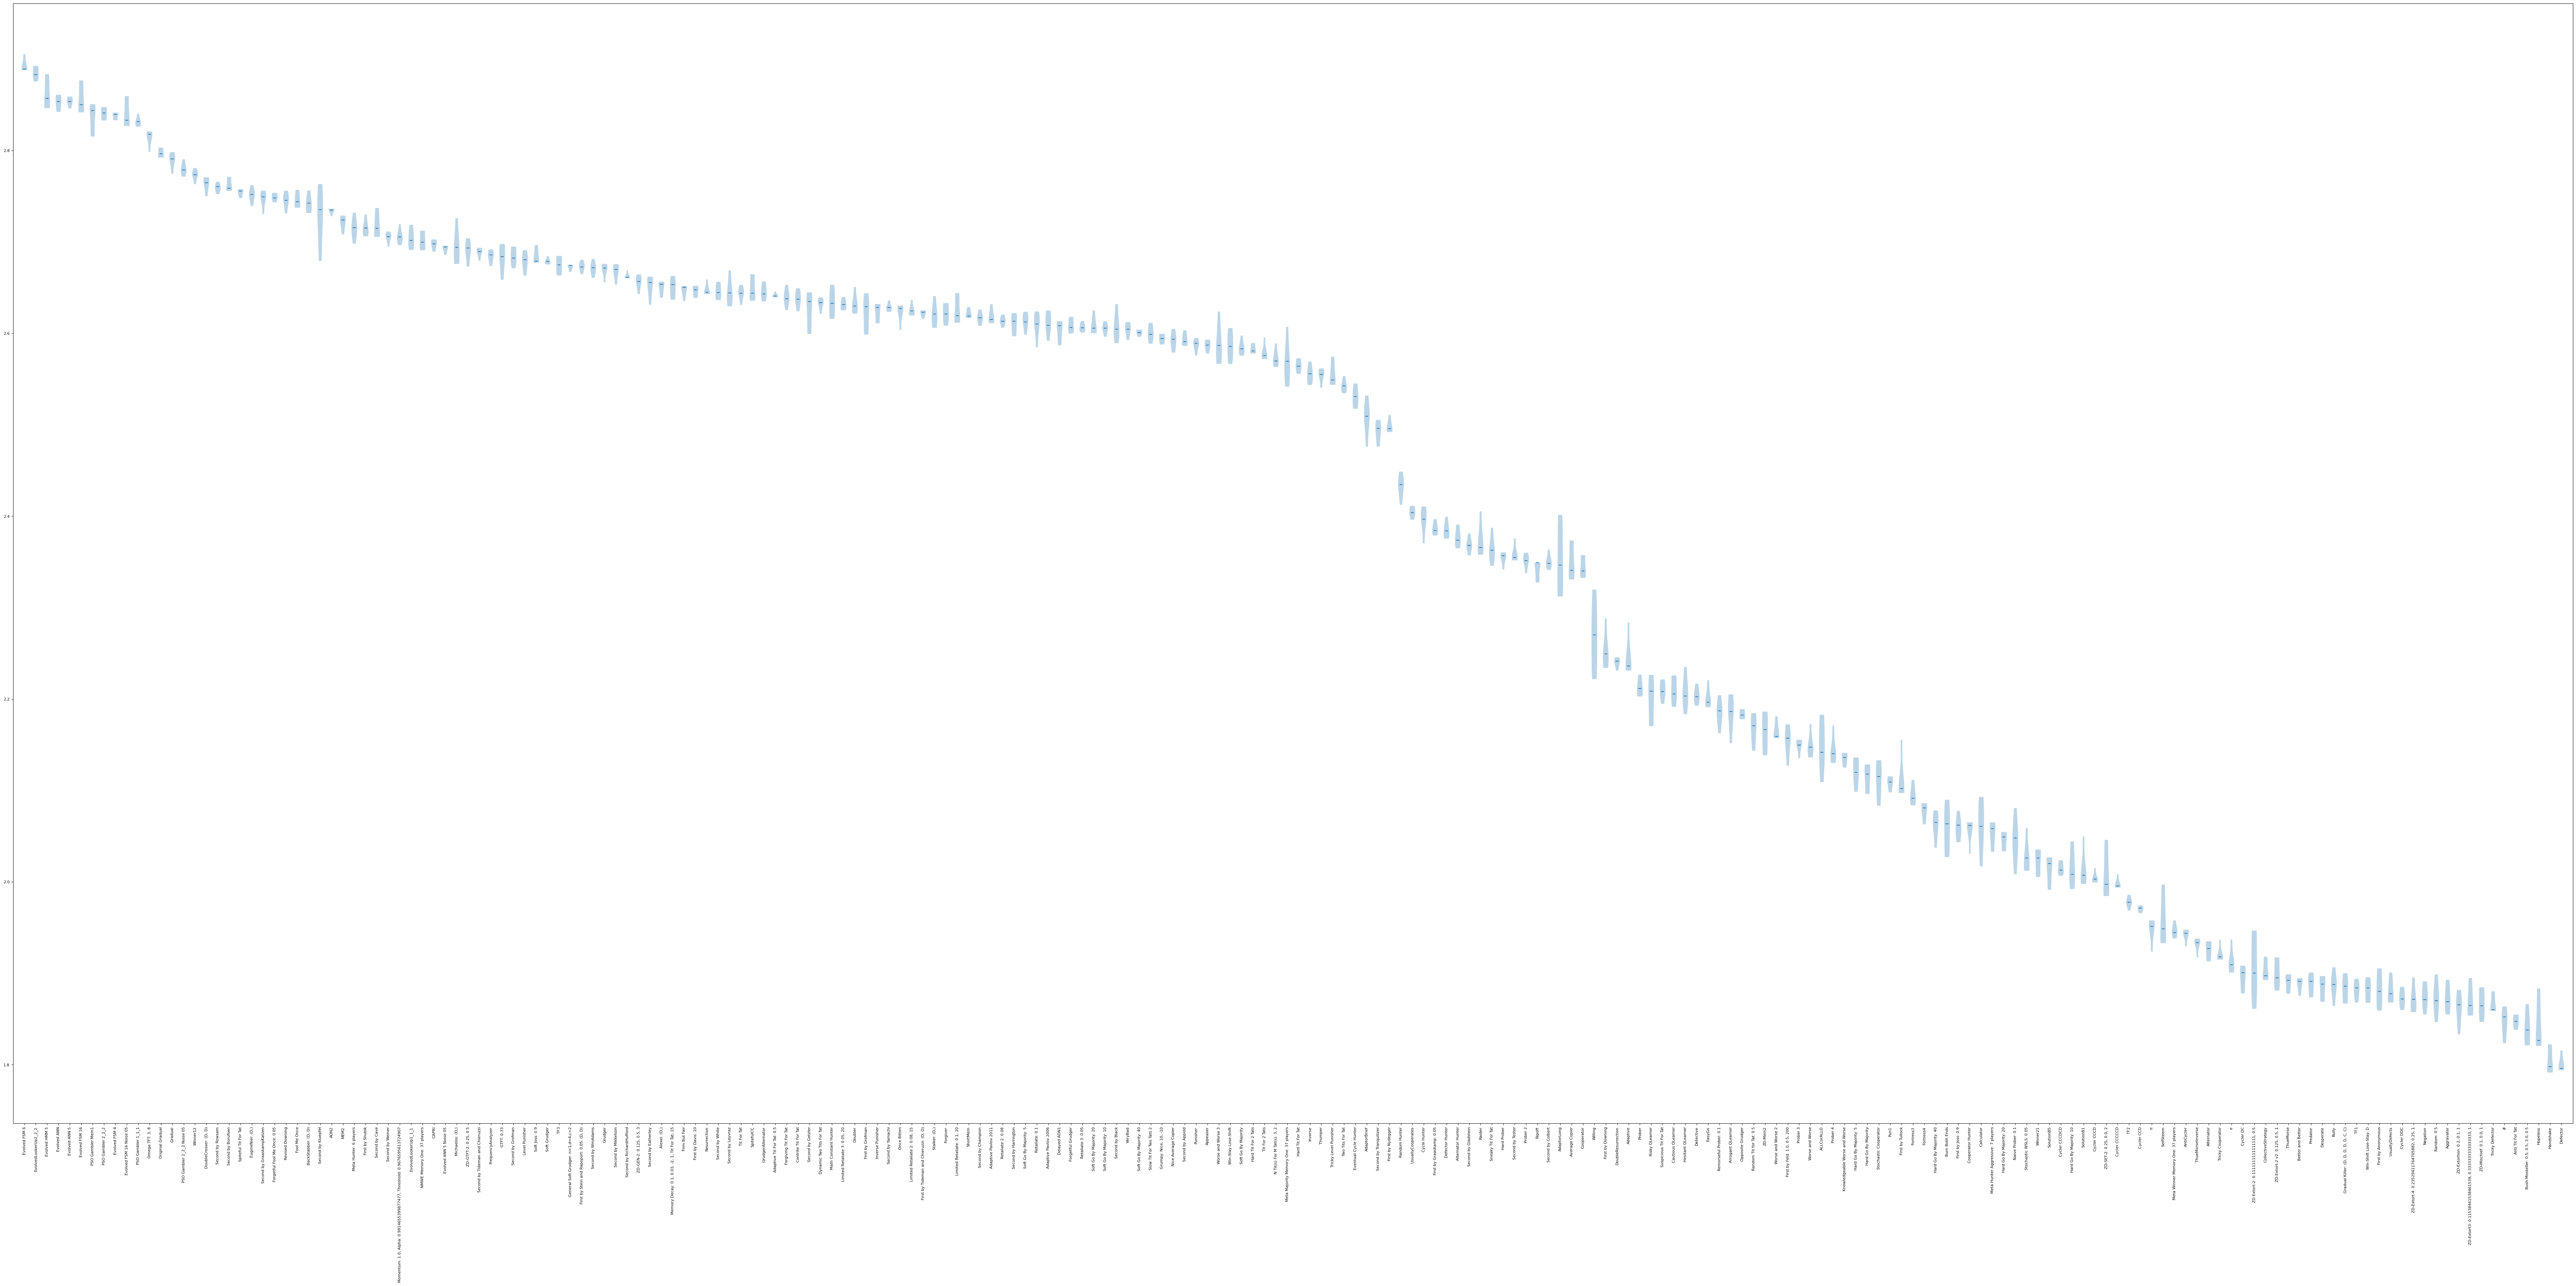

In [38]:
%matplotlib inline
plot = axl.Plot(results)
p = plot.boxplot()

In [39]:
results.write_summary("big_summary.csv")

In [40]:
pairwise_wins = np.zeros((num_players, num_players), dtype=float)

for strat_1 in range(num_players):
    for strat_2 in range(num_players):
        if strat_1 != strat_2:
            wins_1 = 0
            wins_2 = 0
            for rep in range(num_reps):
                score_1 = results.payoffs[strat_1][strat_2][rep]
                score_2 = results.payoffs[strat_2][strat_1][rep]
                if score_1 > score_2:
                    wins_1 += round((score_1-score_2) * num_turns)
            # Save score difference from strat_1 over strat_2 (if positive)
            pairwise_wins[strat_1][strat_2] = wins_1
        else:
            pairwise_wins[strat_1][strat_2] = np.nan    

print("Pairwise wins matrix:\n", pairwise_wins)

Pairwise wins matrix:
 [[  nan  680.   10. ...   40.   40.   10.]
 [   0.   nan    0. ...    0.    0.    0.]
 [   0.    0.   nan ...    0.    0.    0.]
 ...
 [   0.   75.   40. ...   nan    0.    0.]
 [1980. 1615.   20. ...   50.   nan   10.]
 [   0.    0.    0. ...    0.   10.   nan]]


In [41]:
schulze_ranking = schulze_method(pairwise_wins)
print("\nSchulze ranking:")
for pos, idx in enumerate(schulze_ranking, 1):
    print(f"{pos}. {players[idx]}")


Schulze ranking:
1. Aggravater
2. Defector
3. SolutionB5
4. Suspicious Tit For Tat
5. UsuallyDefects
6. CollectiveStrategy
7. ZD-Extortion: 0.2, 0.1, 1
8. Burn Both Ends
9. Calculator
10. CAPRI
11. EugineNier: (D,)
12. EvolvedLookerUp1_1_1
13. First by Feld: 1.0, 0.5, 200
14. First by Joss: 0.9
15. First by Tideman and Chieruzzi: (D, D)
16. Forgetful Grudger
17. FrequencyAnalyzer
18. Grudger
19. Hard Tit For Tat
20. Inverse
21. Inverse Punisher
22. MEM2
23. Michaelos: (D,)
24. Naive Prober: 0.1
25. Prober 3
26. Punisher
27. Remorseful Prober: 0.1
28. Resurrection
29. Retaliate: 0.1
30. Retaliate 2: 0.08
31. Retaliate 3: 0.05
32. Ripoff
33. Second by Gladstein
34. Second by GraaskampKatzen
35. Second by Tester
36. Spiteful Tit For Tat
37. SpitefulCC
38. Thumper
39. Two Tits For Tat
40. Winner21
41. ZD-Extort-4: 0.23529411764705882, 0.25, 1
42. Hard Prober
43. Fool Me Once
44. Prober
45. Raider
46. Winner12
47. ZD-Extort-2: 0.1111111111111111, 0.5
48. ZD-Extort3: 0.11538461538461539, 0.

In [42]:
print("\nAxelrod classic ranking:")
for idx in range (0,num_players):
    print(f"{idx+1}. {results.ranked_names[idx]}")

print("\nSchulze ranking:")
for pos, idx in enumerate(schulze_ranking, 1):
    print(f"{pos}. {players[idx]}")


Axelrod classic ranking:
1. Evolved FSM 6
2. EvolvedLookerUp2_2_2
3. Evolved HMM 5
4. Evolved ANN
5. Evolved ANN 5
6. Evolved FSM 16
7. PSO Gambler Mem1
8. PSO Gambler 2_2_2
9. Evolved FSM 4
10. Evolved FSM 16 Noise 05
11. PSO Gambler 1_1_1
12. Omega TFT: 3, 8
13. Original Gradual
14. Gradual
15. PSO Gambler 2_2_2 Noise 05
16. Winner12
17. DoubleCrosser: (D, D)
18. Second by Rowsam
19. Second by Borufsen
20. Spiteful Tit For Tat
21. EugineNier: (D,)
22. Second by GraaskampKatzen
23. Forgetful Fool Me Once: 0.05
24. Revised Downing
25. Fool Me Once
26. BackStabber: (D, D)
27. Second by Kluepfel
28. AON2
29. MEM2
30. Meta Hunter: 6 players
31. First by Shubik
32. Second by Cave
33. Second by Weiner
34. Momentum: 1.0, Alpha: 0.9914655399877477, Threshold: 0.9676595613724907
35. EvolvedLookerUp1_1_1
36. NMWE Memory One: 37 players
37. CAPRI
38. Evolved ANN 5 Noise 05
39. Michaelos: (D,)
40. ZD-GTFT-2: 0.25, 0.5
41. Second by Tideman and Chieruzzi
42. FrequencyAnalyzer
43. GTFT: 0.33
44. S

In [43]:
classic_ranking = []  # list to match structure of schulze ranking
summary_df = pd.read_csv("big_summary.csv")
for i in range(num_players):
    classic_ranking.append(int(summary_df['Original_index'][i]))

In [44]:
wins = np.zeros((num_players, num_players), dtype=float)

for strat_1 in range(num_players):
    for strat_2 in range(num_players):
        if strat_1 != strat_2:
            wins_1 = 0
            wins_2 = 0
            for rep in range(num_reps):
                score_1 = results.payoffs[strat_1][strat_2][rep]
                score_2 = results.payoffs[strat_2][strat_1][rep]
                if score_1 > score_2:
                    wins_1 += 1 
            # Save win from strat_1 over strat_2 (if score is positive)
            wins[strat_1][strat_2] = wins_1
        else:
            wins[strat_1][strat_2] = np.nan    

print("Pairwise wins matrix:\n", wins)


Pairwise wins matrix:
 [[nan  2.  2. ...  3.  3.  2.]
 [ 0. nan  0. ...  0.  0.  0.]
 [ 0.  0. nan ...  0.  0.  0.]
 ...
 [ 0.  1.  3. ... nan  0.  0.]
 [ 2.  5.  4. ...  5. nan  1.]
 [ 0.  0.  0. ...  0.  2. nan]]


In [45]:
win_based_ranking = win_based_method(wins)
win_based_ranking

[8,
 36,
 25,
 215,
 211,
 92,
 210,
 209,
 208,
 69,
 207,
 112,
 46,
 222,
 17,
 68,
 185,
 203,
 184,
 115,
 20,
 65,
 62,
 41,
 127,
 177,
 197,
 9,
 22,
 70,
 138,
 94,
 180,
 130,
 95,
 131,
 96,
 205,
 161,
 214,
 18,
 220,
 61,
 97,
 183,
 6,
 21,
 4,
 93,
 77,
 35,
 50,
 193,
 63,
 7,
 105,
 42,
 216,
 76,
 181,
 134,
 137,
 200,
 39,
 98,
 188,
 10,
 19,
 182,
 59,
 165,
 170,
 128,
 88,
 31,
 116,
 217,
 135,
 157,
 0,
 13,
 192,
 204,
 141,
 102,
 100,
 142,
 32,
 89,
 73,
 126,
 140,
 195,
 34,
 221,
 103,
 223,
 187,
 133,
 110,
 179,
 186,
 86,
 108,
 107,
 109,
 151,
 104,
 30,
 51,
 40,
 74,
 56,
 33,
 12,
 16,
 101,
 145,
 60,
 15,
 144,
 24,
 154,
 132,
 163,
 71,
 219,
 129,
 189,
 113,
 122,
 2,
 78,
 57,
 3,
 72,
 173,
 87,
 1,
 125,
 202,
 52,
 155,
 23,
 48,
 123,
 49,
 67,
 111,
 55,
 45,
 124,
 178,
 176,
 28,
 54,
 156,
 162,
 120,
 121,
 53,
 106,
 80,
 118,
 174,
 164,
 119,
 166,
 90,
 218,
 206,
 117,
 158,
 38,
 194,
 143,
 146,
 160,
 114,
 201,
 14,
 1

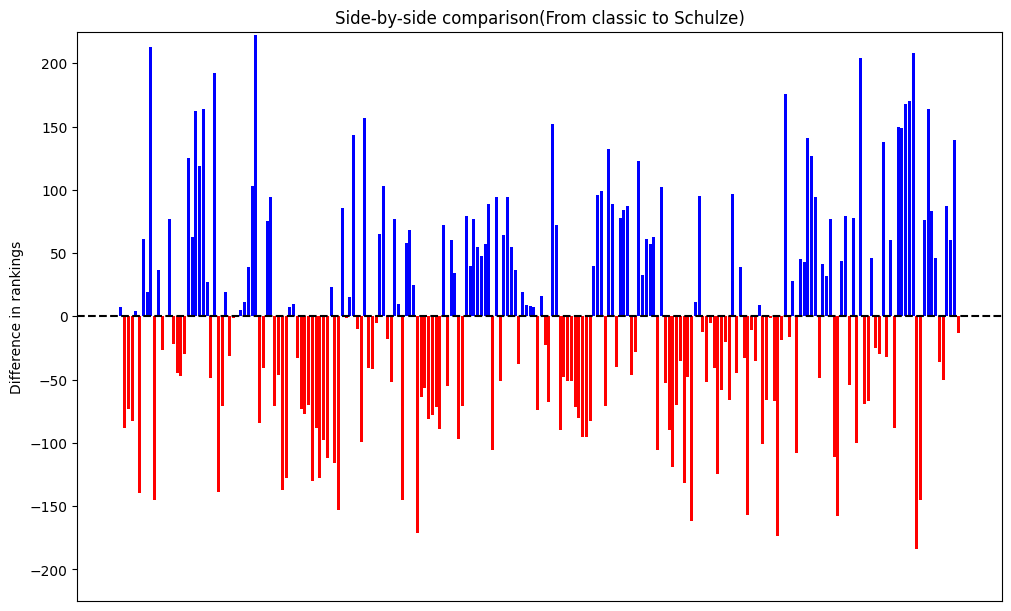

In [46]:
players_names = [p.name for p in players]
diffs = [classic_ranking.index(s) - schulze_ranking.index(s) for s in range(num_players)]

x = np.arange(len(players))
width = 1  
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.bar(players_names,diffs,color=['b' if d >=0 else 'r' for d in diffs ])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Difference in rankings')
ax.set_title('Side-by-side comparison(From classic to Schulze)')
ax.set_ylim(-num_players-1, num_players + 1)
plt.xticks([])
plt.show()

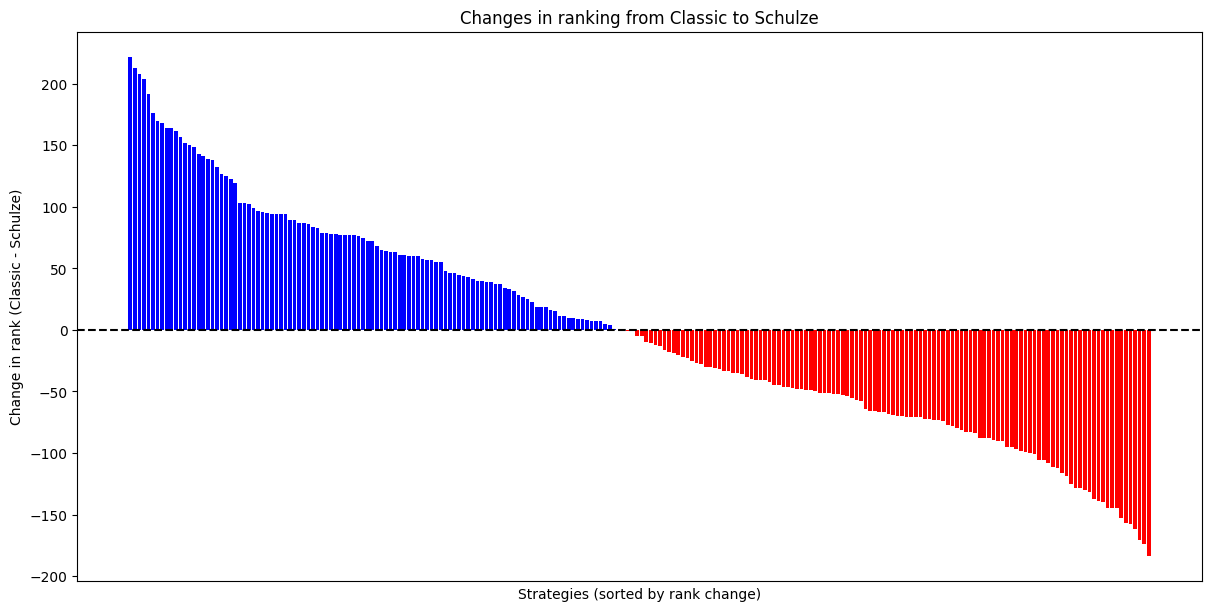

In [47]:
# Combine and sort by improvement
sorted_data = sorted(zip(diffs, players_names), key=lambda x: x[0], reverse=True)
sorted_diffs, sorted_names = zip(*sorted_data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
bars = ax.bar(range(num_players), sorted_diffs, color=['b' if d >= 0 else 'r' for d in sorted_diffs])

ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Change in rank (Classic - Schulze)')
ax.set_xlabel('Strategies (sorted by rank change)')
ax.set_title('Changes in ranking from Classic to Schulze')
ax.set_xticks(range(num_players))
ax.set_xticklabels(sorted_names, rotation=90, fontsize=8)
plt.xticks([])
plt.show()

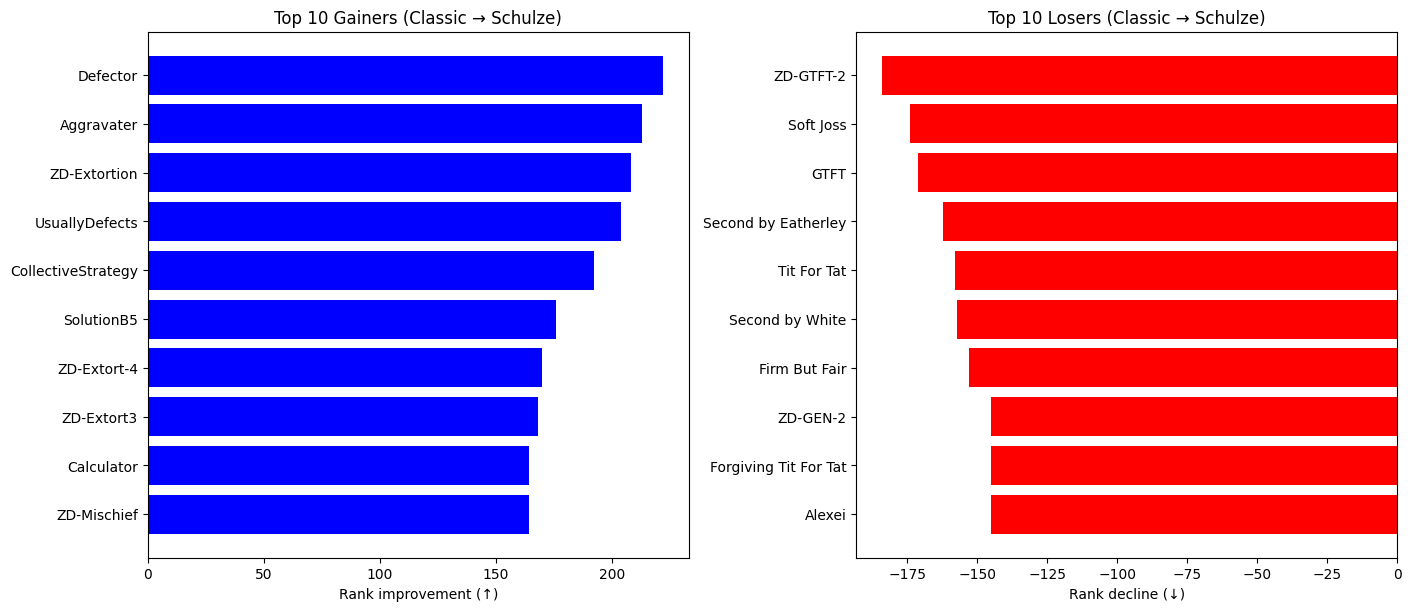

In [48]:

diffs = [classic_ranking.index(s) - schulze_ranking.index(s) for s in range(num_players)]
players_names = [p.name for p in players]

# Combine names and differences
data = list(zip(players_names, diffs))
# Sort by improvement (descending)
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Split into top gainers and top losers
top_gainers = sorted_data[:10]
top_losers = sorted_data[-10:][::-1]  # Reverse to show biggest decline first

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), layout='constrained')

# --- Plot gainers ---
names_g, diffs_g = zip(*top_gainers)
axes[0].barh(names_g, diffs_g, color='b')
axes[0].set_title('Top 10 Gainers (Classic → Schulze)')
axes[0].invert_yaxis()
axes[0].set_xlabel('Rank improvement (↑)')

# --- Plot losers ---
names_l, diffs_l = zip(*top_losers)
axes[1].barh(names_l, diffs_l, color='r')
axes[1].set_title('Top 10 Losers (Classic → Schulze)')
axes[1].invert_yaxis()
axes[1].set_xlabel('Rank decline (↓)')

plt.show()

In [49]:
diffs = np.array([classic_ranking.index(s) - schulze_ranking.index(s) for s in range(num_players)])

# Percentages
num_improved = np.sum(diffs > 0)
num_declined = np.sum(diffs < 0)
num_unchanged = np.sum(diffs == 0)

pct_improved = num_improved / num_players * 100
pct_declined = num_declined / num_players * 100
pct_unchanged = num_unchanged / num_players * 100

# Summary metrics
max_increase = np.max(diffs)
max_decrease = np.min(diffs)

# Display results
print("=== Rank Change Summary (Classic → Schulze) ===")
print(f"Total strategies: {num_players}")
print(f"Improved: {num_improved} ({pct_improved:.2f}%)")
print(f"Declined: {num_declined} ({pct_declined:.2f}%)")
print(f"Unchanged: {num_unchanged} ({pct_unchanged:.2f}%)")
print("\n---  Metrics ---")
print(f"Max improvement: {max_increase}")
print(f"Max decline: {max_decrease}")

=== Rank Change Summary (Classic → Schulze) ===
Total strategies: 224
Improved: 107 (47.77%)
Declined: 116 (51.79%)
Unchanged: 1 (0.45%)

---  Metrics ---
Max improvement: 222
Max decline: -184


In [60]:
num_players = len(classic_ranking)
df = pd.DataFrame({
    "Player": [p.name for p in players],
    "Classic_Rank": [classic_ranking.index(i) + 1 for i in range(num_players)],
    "Schulze_Rank": [schulze_ranking.index(i) + 1 for i in range(num_players)],
    "Win_Rank": [win_based_ranking.index(i) + 1 for i in range(num_players)]
})

# Calculate rank differences (negative = improved)
df["Change_Classic_to_Schulze"] = df["Schulze_Rank"] - df["Classic_Rank"]
df["Change_Classic_to_Win"] = df["Win_Rank"] - df["Classic_Rank"]

# Helper function to summarize change
def summarize_rank_change(change_column):
    n = len(df)
    improved = (df[change_column] < 0).sum()
    declined = (df[change_column] > 0).sum()
    unchanged = (df[change_column] == 0).sum()

    percent_improved = improved / n * 100
    percent_declined = declined / n * 100
    percent_unchanged = unchanged / n * 100

    # Relative change (in % of total ranks)
    df["Relative_Change"] = df[change_column].abs() / n

    thresholds = [0.1, 0.25, 0.5, 0.75]
    stats = {
        "Improved (%)": percent_improved,
        "Declined (%)": percent_declined,
        "Unchanged (%)": percent_unchanged
    }

    for t in thresholds:
        lost_more = ((df["Relative_Change"] > t) & (df[change_column] > 0)).sum() / n * 100
        gained_more = ((df["Relative_Change"] > t) & (df[change_column] < 0)).sum() / n * 100
        stats[f"Lost > {int(t*100)}%"] = lost_more
        stats[f"Gained > {int(t*100)}%"] = gained_more

    return pd.Series(stats)

summary_schulze = summarize_rank_change("Change_Classic_to_Schulze")
summary_win = summarize_rank_change("Change_Classic_to_Win")

summary = pd.DataFrame({
    "Classic→Schulze": summary_schulze,
    "Classic→Win-Based": summary_win
})

#summary.to_csv("rank_change_summary.csv")
print(summary.round(2))

               Classic→Schulze  Classic→Win-Based
Improved (%)             47.77              50.00
Declined (%)             51.79              50.00
Unchanged (%)             0.45               0.00
Lost > 10%               45.54              46.43
Gained > 10%             39.73              42.86
Lost > 25%               29.02              41.96
Gained > 25%             29.91              36.16
Lost > 50%                8.93              22.77
Gained > 50%             10.71              24.11
Lost > 75%                1.34               1.34
Gained > 75%              3.12               7.14


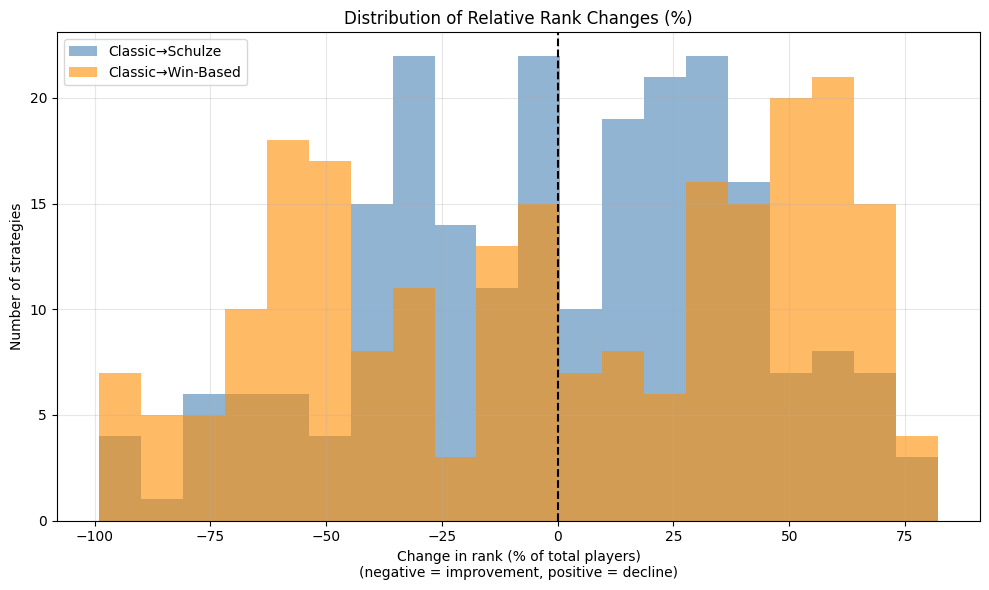

In [61]:
num_players = len(classic_ranking)
df = pd.DataFrame({
    "Player": [p.name for p in players],
    "Classic_Rank": [classic_ranking.index(i) + 1 for i in range(num_players)],
    "Schulze_Rank": [schulze_ranking.index(i) + 1 for i in range(num_players)],
    "Win_Rank": [win_based_ranking.index(i) + 1 for i in range(num_players)]
})

# Calculate absolute and relative changes
df["Δ_Classic→Schulze"] = df["Schulze_Rank"] - df["Classic_Rank"]
df["Δ_Classic→Win"] = df["Win_Rank"] - df["Classic_Rank"]
df["%_Change_Schulze"] = df["Δ_Classic→Schulze"] / num_players * 100
df["%_Change_Win"] = df["Δ_Classic→Win"] / num_players * 100

# ---- HISTOGRAM ----
plt.figure(figsize=(10, 6))
plt.hist(df["%_Change_Schulze"], bins=20, alpha=0.6, label="Classic→Schulze", color='steelblue')
plt.hist(df["%_Change_Win"], bins=20, alpha=0.6, label="Classic→Win-Based", color='darkorange')
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Relative Rank Changes (%)")
plt.xlabel("Change in rank (% of total players)\n(negative = improvement, positive = decline)")
plt.ylabel("Number of strategies")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\kiriz\AppData\Local\Temp\ipykernel_15956\1721741156.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=melted, x="Ranking Method Transition", y="Rank Change (%)", inner="quartile", palette="Set2")


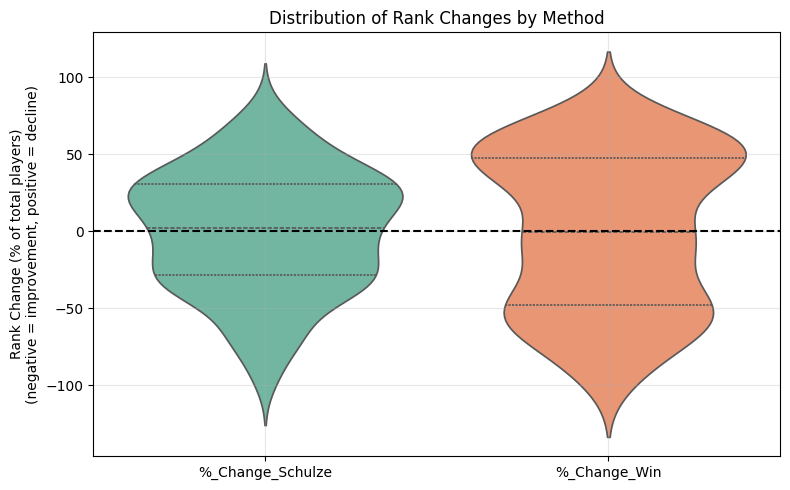

In [68]:
import seaborn as sns
melted = df.melt(value_vars=["%_Change_Schulze", "%_Change_Win"],
                 var_name="Ranking Method Transition",
                 value_name="Rank Change (%)")

plt.figure(figsize=(8, 5))
sns.violinplot(data=melted, x="Ranking Method Transition", y="Rank Change (%)", inner="quartile", palette="Set2")
plt.axhline(0, color='black', linestyle='--')
plt.title("Distribution of Rank Changes by Method")
plt.ylabel("Rank Change (% of total players)\n(negative = improvement, positive = decline)")
plt.xlabel("")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [50]:
all_tournaments_df[all_tournaments_df["Win_Based_Rank"]<5]

,Rank,Schulze_Rank,Win_Based_Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,Original_index,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,3,2,"First by Stein and Rapoport: 0.05: (D, D)",2.583571,0.602929,10.0,1.0,5,0.559143,0.043786,0.128000,0.269071,0.980995,0.238937,0.591605,0.00000
5,5,2,1,"First by Tideman and Chieruzzi: (D, D)",2.458929,0.597286,11.0,1.0,1,0.580000,0.017286,0.080429,0.322286,0.996791,0.083736,0.379202,0.00000
10,10,1,3,"First by Feld: 1.0, 0.5, 200",1.902143,0.290357,10.0,1.0,10,0.231857,0.058500,0.129357,0.580286,0.887230,0.000000,0.810846,0.00000
11,11,6,4,First by Tullock,1.833571,0.311357,8.0,1.0,12,0.240857,0.070500,0.094214,0.594429,0.835630,0.530241,0.612311,0.10837
12,12,0,0,First by Joss: 0.9,1.774286,0.289500,11.0,1.0,11,0.228071,0.061429,0.093357,0.617143,0.862703,0.000000,0.910712,0.00000


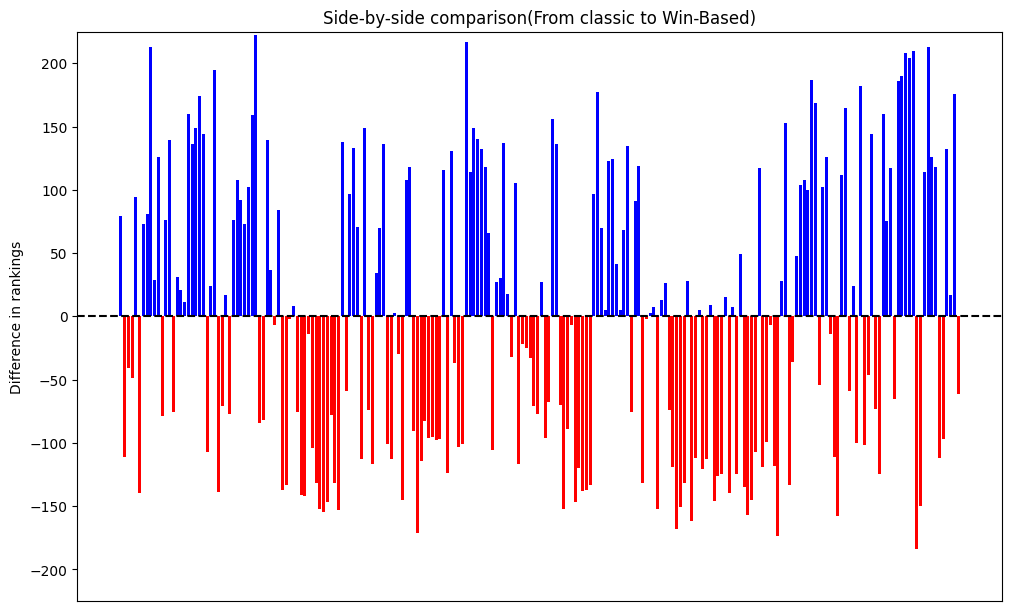

In [51]:
players_names = [p.name for p in players]
diffs = [classic_ranking.index(s) - win_based_ranking.index(s) for s in range(num_players)]

x = np.arange(len(players))
width = 1  
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.bar(players_names,diffs,color=['b' if d >=0 else 'r' for d in diffs ])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Difference in rankings')
ax.set_title('Side-by-side comparison(From classic to Win-Based)')
ax.set_ylim(-num_players-1, num_players + 1)
plt.xticks([])
plt.show()

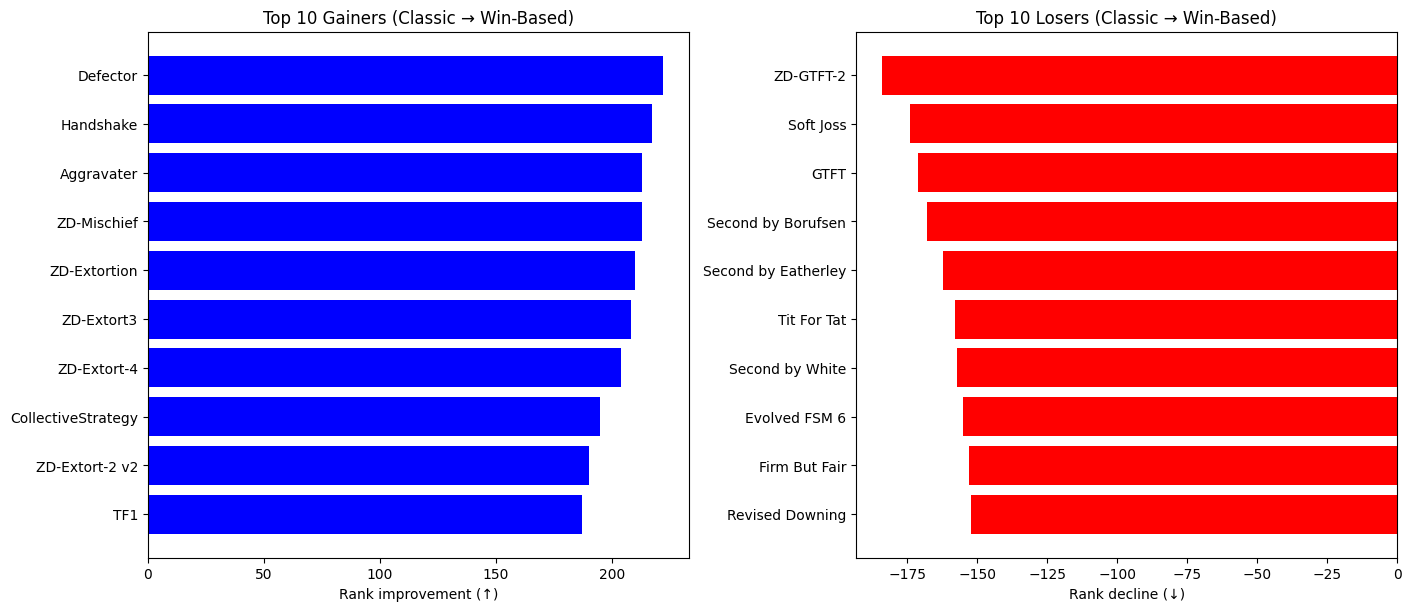

In [52]:
diffs = [classic_ranking.index(s) - win_based_ranking.index(s) for s in range(num_players)]
players_names = [p.name for p in players]

# Combine names and differences
data = list(zip(players_names, diffs))
# Sort by improvement (descending)
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Split into top gainers and top losers
top_gainers = sorted_data[:10]
top_losers = sorted_data[-10:][::-1]  # Reverse to show biggest decline first

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), layout='constrained')

# --- Plot gainers ---
names_g, diffs_g = zip(*top_gainers)
axes[0].barh(names_g, diffs_g, color='b')
axes[0].set_title('Top 10 Gainers (Classic → Win-Based)')
axes[0].invert_yaxis()
axes[0].set_xlabel('Rank improvement (↑)')

# --- Plot losers ---
names_l, diffs_l = zip(*top_losers)
axes[1].barh(names_l, diffs_l, color='r')
axes[1].set_title('Top 10 Losers (Classic → Win-Based)')
axes[1].invert_yaxis()
axes[1].set_xlabel('Rank decline (↓)')
plt.show()

In [53]:
diffs = np.array([classic_ranking.index(s) - win_based_ranking.index(s) for s in range(num_players)])

# Percentages
num_improved = np.sum(diffs > 0)
num_declined = np.sum(diffs < 0)
num_unchanged = np.sum(diffs == 0)

pct_improved = num_improved / num_players * 100
pct_declined = num_declined / num_players * 100
pct_unchanged = num_unchanged / num_players * 100

# Summary metrics
max_increase = np.max(diffs)
max_decrease = np.min(diffs)

# Display results
print("=== Rank Change Summary (Classic → Win-Based) ===")
print(f"Total strategies: {num_players}")
print(f"Improved: {num_improved} ({pct_improved:.2f}%)")
print(f"Declined: {num_declined} ({pct_declined:.2f}%)")
print(f"Unchanged: {num_unchanged} ({pct_unchanged:.2f}%)")
print("\n---  Metrics ---")
print(f"Max improvement: {max_increase}")
print(f"Max decline: {max_decrease}")

=== Rank Change Summary (Classic → Win-Based) ===
Total strategies: 224
Improved: 112 (50.00%)
Declined: 112 (50.00%)
Unchanged: 0 (0.00%)

---  Metrics ---
Max improvement: 222
Max decline: -184


In [54]:
all_tournaments_df = pd.read_csv("big_summary.csv")    # All tournaments rankings and main metrics
schulze_rank_map = {idx: rank  for rank, idx in enumerate(schulze_ranking)}
win_rank_map = {idx: rank  for rank, idx in enumerate(win_based_ranking)}

# Add new columns to the dataframe by mapping
all_tournaments_df["Schulze_Rank"] = all_tournaments_df["Original_index"].map(schulze_rank_map)
all_tournaments_df["Win_Based_Rank"] = all_tournaments_df["Original_index"].map(win_rank_map)

new_order = ["Rank","Schulze_Rank", "Win_Based_Rank"] + [col for col in all_tournaments_df.columns if col not in ["Rank","Schulze_Rank", "Win_Based_Rank"]]
all_tournaments_df = all_tournaments_df[new_order]
# Save to file
all_tournaments_df.to_csv("big_all_tournaments_rankings.csv", index=False)

# Normalised ranks
all_tournaments_df_norm = all_tournaments_df
rank_cols = ["Rank", "Schulze_Rank", "Win_Based_Rank"]
for col in rank_cols:
    min_val = all_tournaments_df[col].min()
    max_val = all_tournaments_df[col].max()
    all_tournaments_df_norm[col] = (all_tournaments_df[col] - min_val) / (max_val - min_val)
all_tournaments_df_norm.to_csv("big_all_tournaments_rankings_norm.csv", index=False)
all_tournaments_df = pd.read_csv("big_all_tournaments_rankings.csv")

In [55]:
compute_rank_correlations(all_tournaments_df)

{'score_vs_wins': np.float64(-0.546234251548153),
 'score_vs_schulze': np.float64(0.06382660687593424),
 'wins_vs_schulze': np.float64(0.5363954729874013)}

In [77]:
compute_any_correlations(all_tournaments_df,"DD_to_C_rate")

{'Classic': np.float64(0.1996631101584481),
 'Win-Based': np.float64(0.0767765954914242),
 'Schulze': np.float64(0.37553239644627595)}

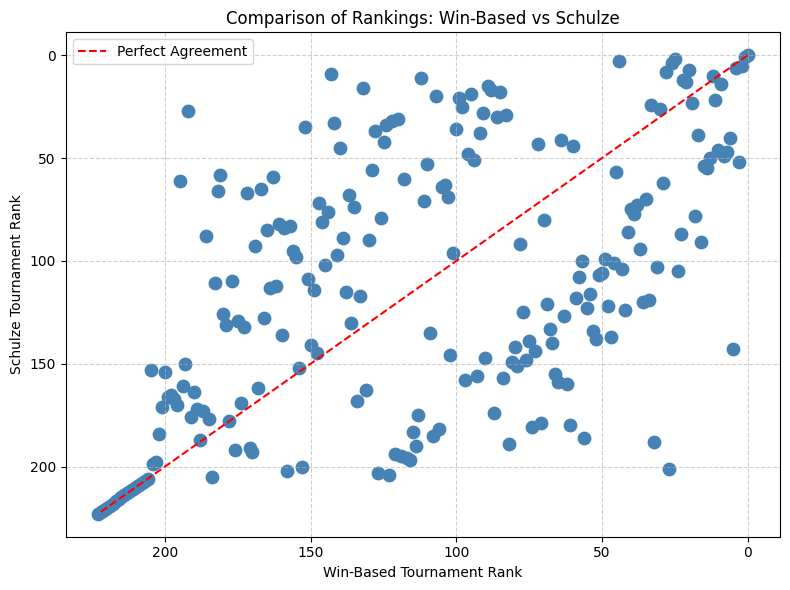

In [79]:
classic_ranks = all_tournaments_df["Win_Based_Rank"]
schulze_ranks = all_tournaments_df["Schulze_Rank"]
names = all_tournaments_df["Strategy"] if "Strategy" in all_tournaments_df.columns else all_tournaments_df["Name"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(classic_ranks, schulze_ranks, color='steelblue', s=80)



# Add diagonal (line of perfect agreement)
plt.plot([min(classic_ranks), max(classic_ranks)], 
         [min(classic_ranks), max(classic_ranks)], 
         'r--', label='Perfect Agreement')

# Axis labels and title
plt.xlabel("Win-Based Tournament Rank")
plt.ylabel("Schulze Tournament Rank")
plt.title("Comparison of Rankings: Win-Based vs Schulze")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [94]:
model = smf.ols('Schulze_Rank ~ Median_score + Initial_C_rate + CC_rate + DD_rate  + CC_to_C_rate + DD_to_C_rate', data=all_tournaments_df_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Schulze_Rank   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     37.20
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           7.36e-31
Time:                        15:38:15   Log-Likelihood:                 38.694
No. Observations:                 224   AIC:                            -63.39
Df Residuals:                     217   BIC:                            -39.51
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8976      0.191      9.

In [95]:
model = smf.ols('Rank ~ Median_score + Initial_C_rate + CC_rate + DD_rate  + CC_to_C_rate + DD_to_C_rate', data=all_tournaments_df_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     744.1
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          1.02e-141
Time:                        15:53:28   Log-Likelihood:                 303.48
No. Observations:                 224   AIC:                            -593.0
Df Residuals:                     217   BIC:                            -569.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.7543      0.059     46.

In [96]:
model = smf.ols('Win_Based_Rank ~ Median_score + Initial_C_rate + CC_rate + DD_rate  + CC_to_C_rate + DD_to_C_rate', data=all_tournaments_df_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win_Based_Rank   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     90.78
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           2.12e-56
Time:                        15:53:39   Log-Likelihood:                 100.10
No. Observations:                 224   AIC:                            -186.2
Df Residuals:                     217   BIC:                            -162.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3499      0.145      2.

In [90]:
X = all_tournaments_df[['Initial_C_rate' , 'CC_rate', 'DD_rate'  , 'CC_to_C_rate' , 'DD_to_C_rate',"Median_score"]]
X = sm.add_constant(X) 

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


print(vif_data)

          feature         VIF
0           const  191.408214
1  Initial_C_rate    1.316480
2         CC_rate   16.589954
3         DD_rate    7.930909
4    CC_to_C_rate    2.903846
5    DD_to_C_rate    2.498228
6    Median_score    4.832174
